# 캐글따라하기(bike sharing demand)


지금까지 머신러닝에 대해 공부하면서 머신러닝의 목적은 데이터를 통해 모델을 만들어 문제를 해결하는 것이라고 배웠다. 즉, 학습 데이터로 모델을 구축하고 모델에 새로운 데이터를 적용하면 다양한 문제를 예측할 수 있다. 이때 학습 데이터에 정답이 포함되어 있을 경우 지도 학습, 그렇지 않은 경우 비지도 학습이라고 한다. 그리고 해결하고자 하는 문제에 따라 학습 알고리즘을 다르게 선택해야 한다. 이번 블로그에서는 간단한 머신러닝 프로젝트 과정을 통해 머신러닝의 주요 단계를 이해하고 실제로 머신러닝 모델로 어떤 문제를 어떻게 해결할 수 있는 지를 소개하겠다. 예측한 결과를 캐글사이트에 제출하는 것까지 해보자.

이번 자전거 대여량 예측은 위에서 얘기했던 지도학습에 있는 분류와 회귀 문제 중 대여량을 예측하는 것이기 때문에 회귀 문제에 속한다.

출처 : [Tutorial with Bike Sharing Demand](https://www.kaggle.com/sidagar/tutorial-with-bike-sharing-demand), [원투잽님 티스토리](https://onetwojab.tistory.com/7)

이번 블로그의 주제는 워싱턴 DC의 Capital Bikeshare 프로그램에서 자전거 대여 수요를 예측하는 것이다. 예를 들면 서울시에서 자전거를 대여해 주는 따릉이와 같다고 보면 될 것 같다.
내려 받은 데이터는 날짜 및 시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격의 자전거 대여 횟수를 기록한 데이터이다.
기록 날짜는 2011년 1월 ~ 2012년 12월까지이다.

들어가기에 앞서 사람들이 자전거를 대여하는 이유는 다양할 것이다. 예로는 출,퇴근 시간에 대여량이 더 많을 것이고, 비나 눈이 오는 날씨에는 자전거를 탈수 없어 대여량이 적어질 것이다. 또한 평일보다는 공휴일이나 주말에 나들이를 많이 나오기 때문에 자전거를 더 많이 대여할 것이다. 이러한 변수들을 고려하여 좋은 예측이 나오길 기대해 보자.

## 1. 데이터 불러오기

먼저 필요한 라이브러리들을 불러오자.

In [28]:
import numpy as np
import pandas as pd

In [29]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

In [30]:
# 한글 폰트 깨짐 방지
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

훈련용 데이터와 테스트용 데이터를 각각 불러온 다음 데이터의 형태를 파악해 보자.

In [31]:
train = pd.read_csv('/home/jaeyoon89/jaeyoon_study/train_bike.csv')
test = pd.read_csv('/home/jaeyoon89/jaeyoon_study/test_test.csv')

# 데이트 타임 형식으로 불러오기 parse_dates를 사용
train = pd.read_csv('/home/jaeyoon89/jaeyoon_study/train_bike.csv',parse_dates=["datetime"])
test = pd.read_csv('/home/jaeyoon89/jaeyoon_study/test_test.csv',parse_dates=["datetime"])

훈련용 데이터와 테스트용 데이터를 각각 불러온 다음 데이터의 형태를 파악해 보자.

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   int64         
 2   holiday     6493 non-null   int64         
 3   workingday  6493 non-null   int64         
 4   weather     6493 non-null   int64         
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   int64         
 8   windspeed   6493 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


위 컬럼들에 대한 의미를 알아보면 다음과 같다.
- datetime: 연,월,일에 대한 시간 데이터
- season: 1 : spring , 2 = summer, 3 = fall, 4 = winter
- holiday: 공휴일, 주말
- workingday: 공휴일, 주말을 제외한 평일
- weather : 1 ~ 4 ( 숫자가 높을 수록 날씨가 좋지 않음을 의미)
- temp: 기온
- atemp: 체감온도
- humidity: 습도
- windspeed: 바람의 세기
- casual: 비회원의 대여량
- registered: 회원의 대여량
- count: 총 대여량

결측치가 있는지 확인해보니 train 데이터에는 결측치가 없는 것으로 나온다.

In [34]:
train.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## 2. 연속적인 데이터의 시각화

다음으로 예측에 필요한 컬럼들끼리의 상관관계를 알아보기 위한 heatmap을 그려보자.

In [35]:
corr = train[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()

<AxesSubplot:>

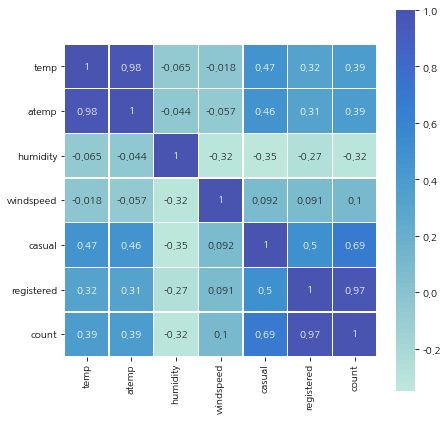

In [36]:
f,axes = plt.subplots(1,1,figsize = (7,7))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 2,ax = axes)

위 heatmap을 보면 온도와 체감온도가 매우 강한 양의 상관 관계를 가지고 있다는 것을 알 수 있다. 그렇기 때문에 온도와 체감온도만 변수로 사용할 수 있을 것 같다. 또한 위 heatmap에서 windspeed(풍속)은 우리가 예측하고자 하는 casual(비회원), retistered(회원) 또는 대여수량에 상관관계가 없다는 것을 볼 수 있다. 예측하는데 있어 제거해도 무방할 듯 하다.

위 히트맵에서 상관관계가 없어보이는 temp, windspeed, humidity에 따른 자전거 대여량을 산점도 그래프를 그려보자.

<AxesSubplot:xlabel='humidity', ylabel='count'>

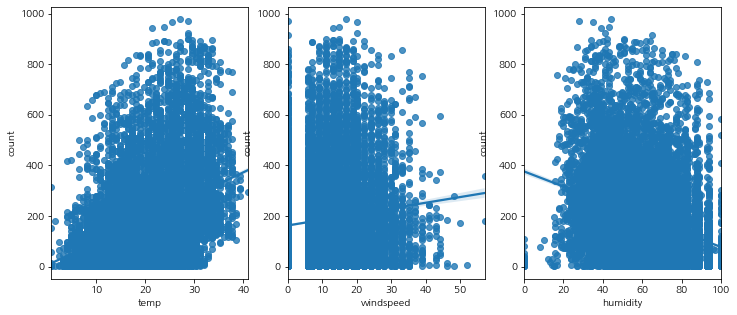

In [37]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sb.regplot(x="temp",y="count",data=train, ax=ax1)
sb.regplot(x="windspeed",y="count",data=train, ax=ax2)
sb.regplot(x="humidity",y="count",data=train, ax=ax3)

windspeed의 경우 일부 데이터가 0에 몰려 있는 것이 확인 된다. 실제로 관측된 값이 0일수도 있고, 혹은 관측이 되지 않아서 결측치를 0으로 채워넣은 값일 수도 있다.
humidity의 경우도 일부 데이터가 0과 100에 몰려 있는 것이 확인 된다. 이것은 아래에서 전처리 해보도록 하자.


풍속은 밑에서 추가적인 전처리를 해 볼 것이다.

## 3. 비연속적인 데이터의 시각화

먼저 각 데이터의 컬럼에 따라 날짜와 시간을 시간, 일, 월 및 년으로 구분해야 한다.
위에서 데이터의 타입을 확인하니 날짜 데이터가 object 이다. 날짜 데이터를 보다 쉽게 조회하기 위해 아래와 같이 datetime 타입으로 변경한 후 시각화를 해보자.

In [38]:
train = train
train['Date'] = pd.DatetimeIndex(train['datetime']).date
train['Hour'] = pd.DatetimeIndex(train['datetime']).hour
train['Day'] = pd.DatetimeIndex(train['datetime']).day
train['Month'] = pd.DatetimeIndex(train['datetime']).month
train['Year'] = pd.DatetimeIndex(train['datetime']).year

<AxesSubplot:xlabel='Date', ylabel='registered'>

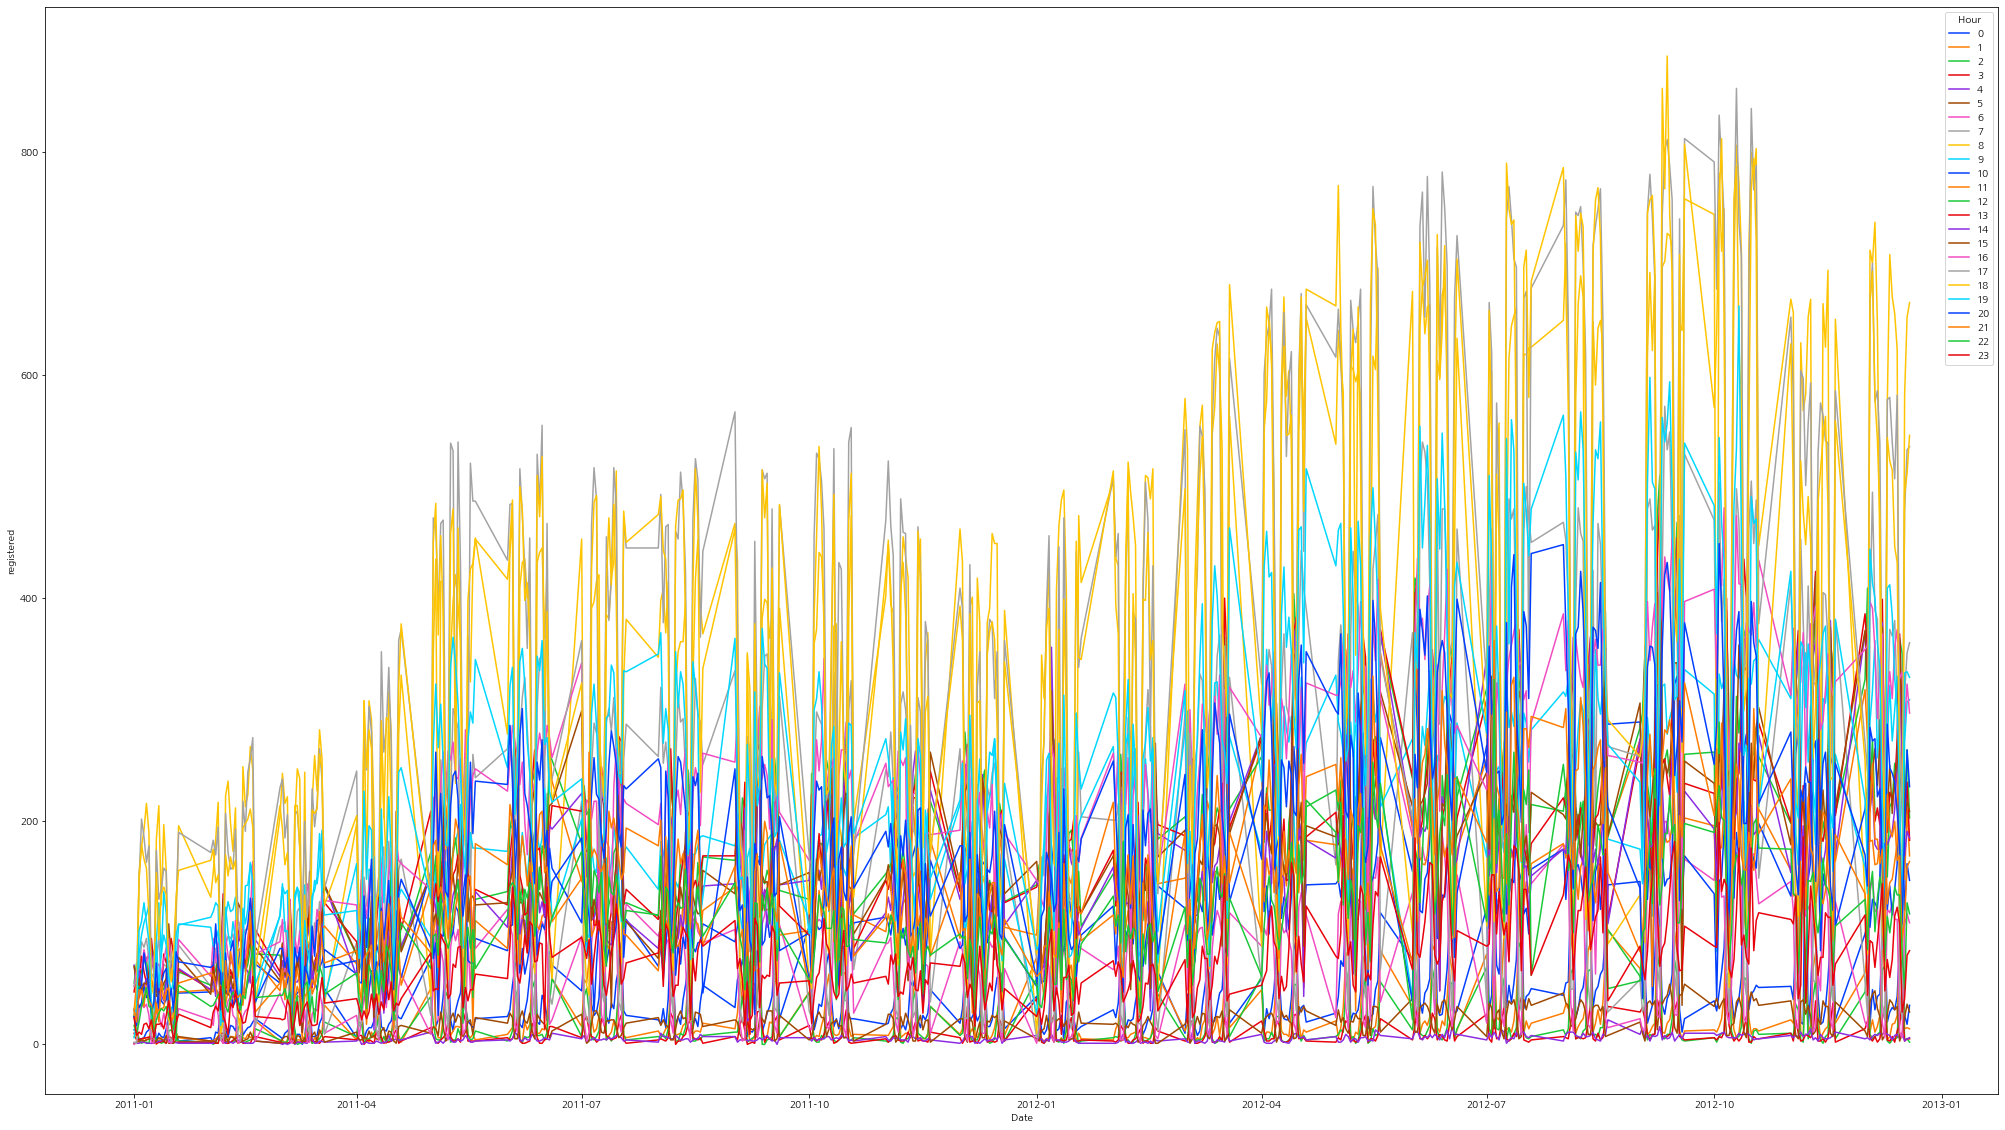

In [39]:
f,axes = plt.subplots(1,1,figsize = (35,20))
sb.lineplot(x ='Date', y = 'registered', data = train, hue = 'Hour',ax = axes,legend = 'full',palette = 'bright')

위 그래프는 2011년 1월부터 2012년 12월까지 월,일,시,요일 에 따른 자전거 대여량에 대한 그래프이다. 중간에 그래프가 급변하는 구간은 데이터가 누락 되어있기 때문이다. 이 구간들이 우리가 결과를 예측해야 하는 구간이다.

### 1. Season

먼저 계절에 따른 비회원, 회원, 총 대여량 에 대해 시각화 해보자.

[Text(0.5, 1.0, '총 대여량')]

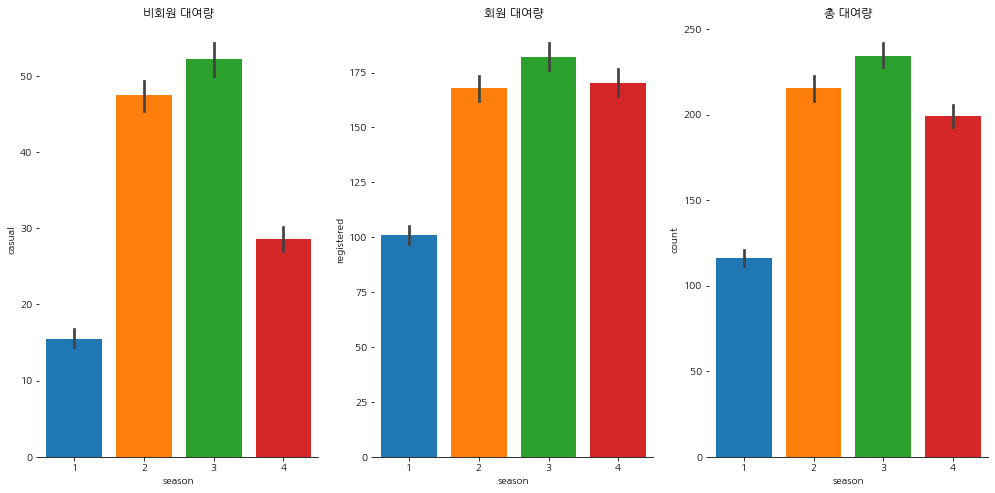

In [40]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])


axes[0].set(title="비회원 대여량")
axes[1].set(title="회원 대여량")
axes[2].set(title="총 대여량")

x축의 1,2,3,4 는 계절을 뜻한다. 1은 spring, 2는 summer, 3은 fall, 4는 winter 이다. 첫 번째 그래프는 비회원들의 대여 수량을 나타낸 그래프이고 두 번째는 회원들의 대여수량 그리고 마지막 세 번째 그래프는 총 대여 수량을 나타낸다.

겨울에 회원과 비회원의 대여수량이 차이가 나는 것을 볼 수 있다. 날씨가 가장 좋은 봄에서 차이나는게 조금 이상해 보인다. 하지만 여름과 가을은 거의 비슷한 대여 수량을 보인다. 아마 날씨가 좋기 때문에 많은 회원, 비회원을 떠나 자전거를 많이 빌린 듯 하다.

그리고 다음으로 seoson에 따른 시간대별 자전거 대여량을 pointplot으로 그려보자.

<AxesSubplot:xlabel='Hour', ylabel='count'>

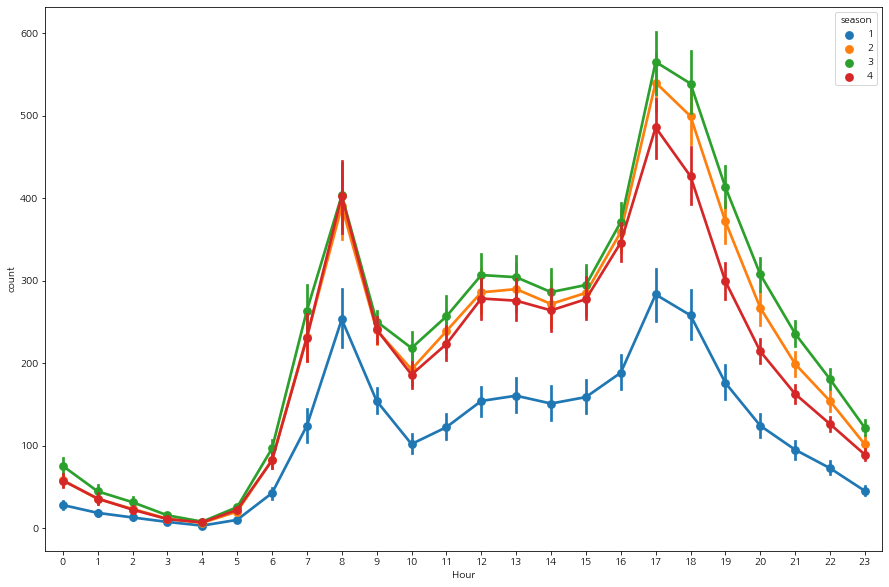

In [41]:
fig,ax2= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

sb.pointplot(data=train, x="Hour", y="count", hue="season", ax=ax2)

season에 따른 시간대별 자전거 대여량 그래프도 봄에 가장 대여량이 적고 가을에 가장 많다는 것을 볼 수 있다.

### 2. Holiday

공휴일, 주말에 따른 비회원, 회원, 총 대여량에 대해 시각화 해보자.

[Text(0.5, 1.0, '총 대여량')]

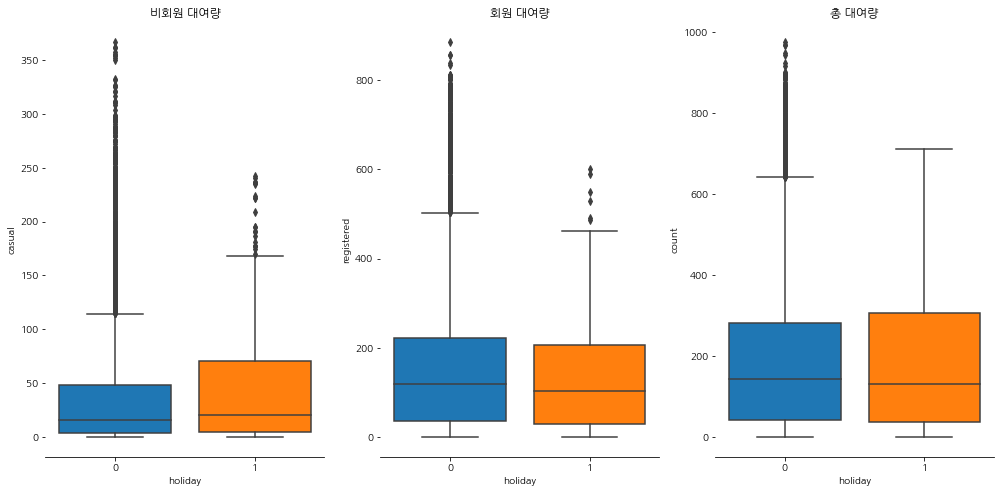

In [42]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'holiday'

sb.boxplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.boxplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.boxplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

axes[0].set(title="비회원 대여량")
axes[1].set(title="회원 대여량")
axes[2].set(title="총 대여량")

위 그래프는 휴일에 따른 대여량을 나타낸 그래프이다. 회원으로 등록된 사람들이 휴일에는 자전거를 비회원보다 빌리지 않은 것으로 보인다. 총 대여량은 휴일일 때와 아닐때의 차이가 거의 없어 보인다.

### 3. Working day

다음으로 평일에 따른 대여량을 확인해 보자.

[Text(0.5, 1.0, '총 대여량')]

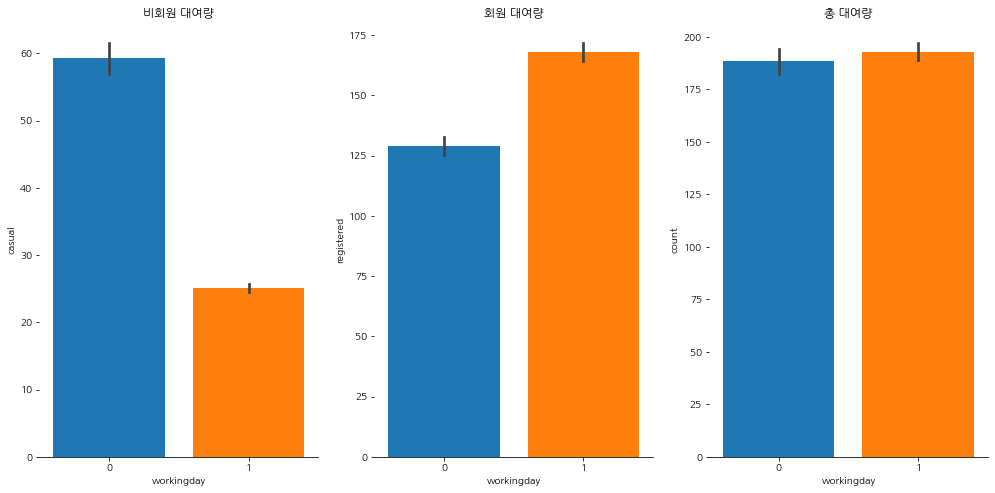

In [43]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

axes[0].set(title="비회원 대여량")
axes[1].set(title="회원 대여량")
axes[2].set(title="총 대여량")

비회원들의 그래프를 합치면 휴일 및 근무일에 영향을 받지 않는 것처럼 보일 수 있지만, 휴일이 비회원의 대여량을 최대 40%까지 증가시키고 근무일에 뒤바뀌는 경향을 볼 수 있다. 따라서 비회원에 대해 두 가지 모델을 각각 다른 모델로 선택하는 것이 좋아 보인다.

따라서 제가 비회원 대여량을 두 개의 모델로 만들고 등록된 모델들을 따로 훈련시킨 다음 그 결과를 합산해 보려고 한다.

### 4. Weather

이번엔 날씨에 따른 비회원, 회원, 총 대여량에 대해 알아보자.

[Text(0.5, 1.0, '총 대여량')]

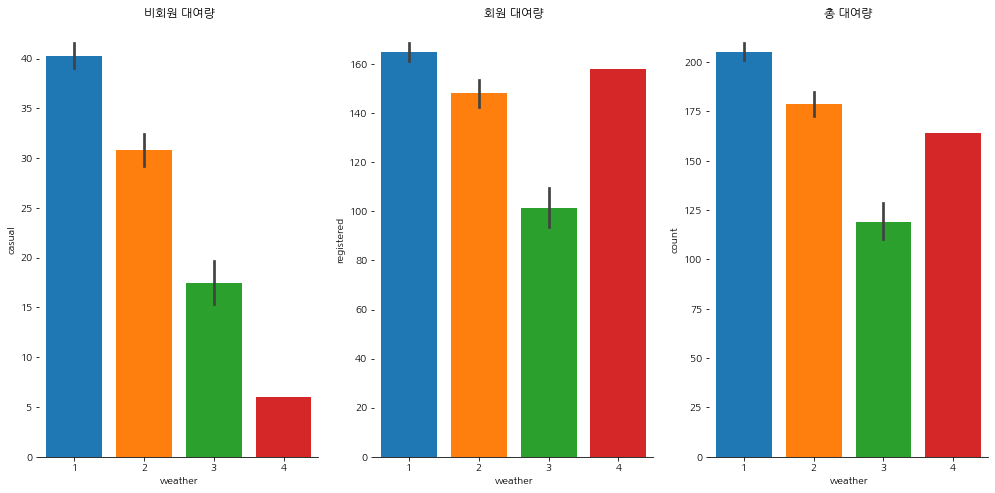

In [44]:
f,axes = plt.subplots(1,3,figsize = (17,8))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = train, saturation = 1, ax = axes[2])

axes[0].set(title="비회원 대여량")
axes[1].set(title="회원 대여량")
axes[2].set(title="총 대여량")

날씨에 따른 대여량의 차이를 나타내 본 그래프이다. 1 ~ 4 라는 숫자는 높을 수록 날씨가 가장 안 좋다는 것을 의미한다. 회원 대여량과 총 대여량을 보면 날씨가 가장 안 좋은 날에 오히려 대여량이 많았다. 날씨는 대여량과의 상관관계가 낮음을 볼 수 있다.

조금 이상해서 날씨에 따른 시간대별 자전거 대여량을 시각화 해보았다. 아이러니 하게도 날씨가 가장 안좋은 4일 때 시간대별 자전거 대여량이 거의 없다고 보여진다. 이 차이는 이는 위에선 컬럼을 비회원, 회원, 총 대여량으로 나누어 시각화 했기 때문에 그런 것 같았다.

<AxesSubplot:xlabel='Hour', ylabel='count'>

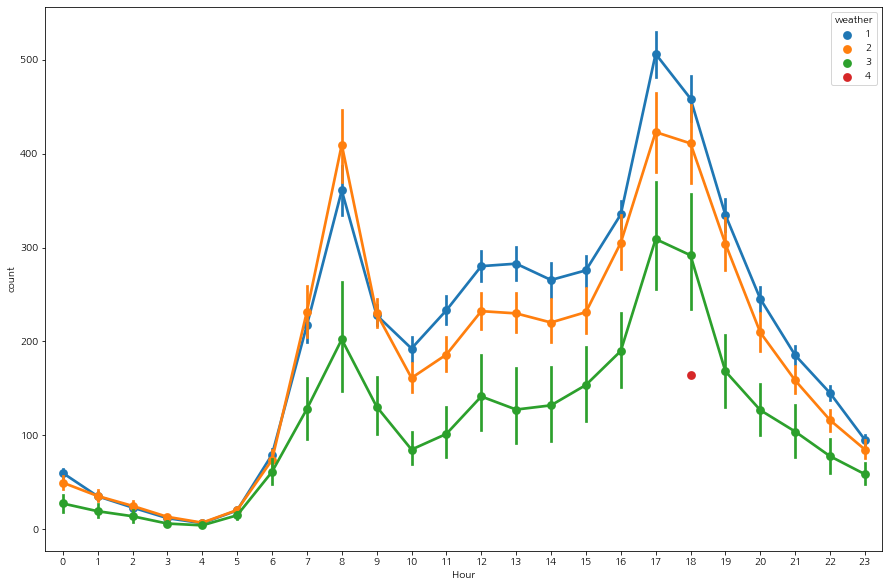

In [45]:
fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

sb.pointplot(data=train, x="Hour", y="count", hue="weather",ax=ax1)

### 5. Date & Time

다음으로 시,일,월,연 별로 자전거 대여량을 시각화 해보자. 앞서 Season, Holiday, Workinday, Weather에 따른 비회원, 회원으로 나누어 자전거 대여량을 확인해 보았지만 시,일,월,연에 따른 자전거 대여량을 확인하는 데에 굳이 나눌 필요가 없다고 생각되어 그래프를 하나로 그려 확인해 보았다.

<AxesSubplot:xlabel='Hour', ylabel='count'>

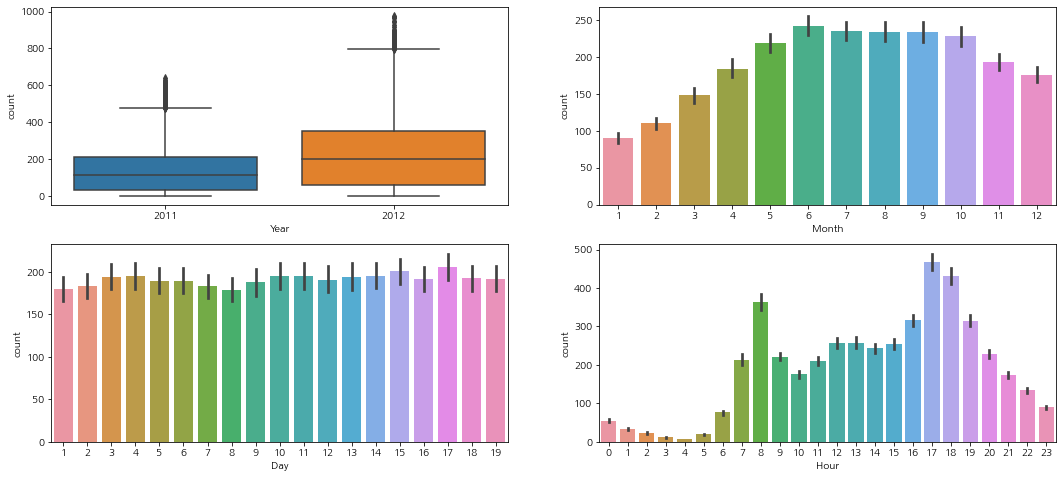

In [46]:
figure, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(18,8)

sb.boxplot(data=train, x="Year", y="count", ax=ax1)
sb.barplot(data=train, x="Month", y="count", ax=ax2)
sb.barplot(data=train, x="Day", y="count", ax=ax3)
sb.barplot(data=train, x="Hour", y="count", ax=ax4)

2011년과 2012년의 대여량을 비교해 보면 2012년의 대여량이 크게 증가한 것을 볼 수 있다.
월별 자전거 대여량은 6월에 가장 많고 7월에서 10월까지의 대여량도 많았다. 그리고 1월에 가장 적은 대여량을 보인다.
일별대여량은 1일부터 19일까지만 있다. 나머지는 test 데이터에 있어 이 데이터는 피처로 사용할 수 없다.
시간 대 대여량을 보면 출퇴근 시간에 대여량이 많다. 

dayofweek도 train 데이터 프레임에 담아봐서 한번 보도록하자.

In [47]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 18)

In [48]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

0 ~ 6 숫자는 월,화,수,목,금,토,일을 나태내고, 요일별 대여량의 차이는 크게 없는 것을 확인 할 수 있다.

### 6. 월별 데이터로 모아보기 

이번엔 월별 데이터로 모아보자.

In [49]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month) #연과 월을 붙여서 확인

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 19)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

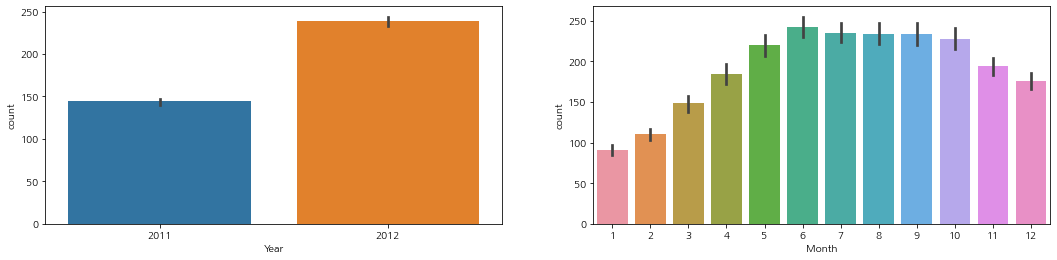

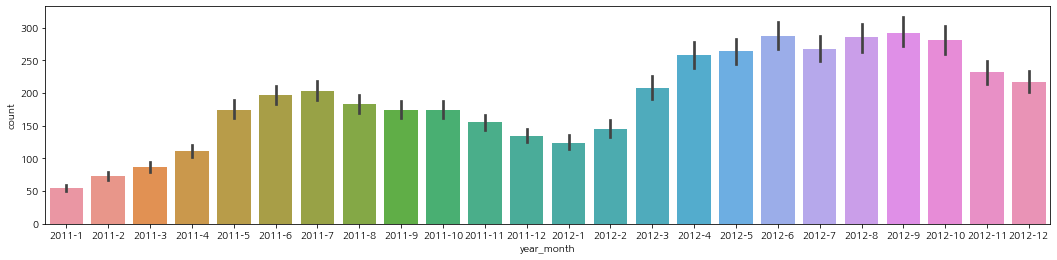

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sb.barplot(data=train, x="Year", y="count", ax=ax1)
sb.barplot(data=train, x="Month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sb.barplot(data=train, x="year_month", y="count", ax=ax3)

위 결과를 보니 앞서 살펴 보았던과 같이 2011년보다는 2012년에 대여량이 많았고 겨울보단 여름에 대여량이 많았다. 그리고 마지막 세 번째 그래프를 보면 대여량이 계속해서 증가하는 추세를 보이고 있다. 

Outlier 데이터를 제거하고 보려한다. 위에서 그려보았던 온도와 풍속,습도의 산점도 그래프에 0과 100에 몰려 있던 데이터를 제거하자.

In [51]:
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 19)
(10739, 19)


제거한 데이터로 distplot, probplot로 그려봐서 제거 전과 비교 해 보자.

/home/jaeyoon89/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jaeyoon89/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

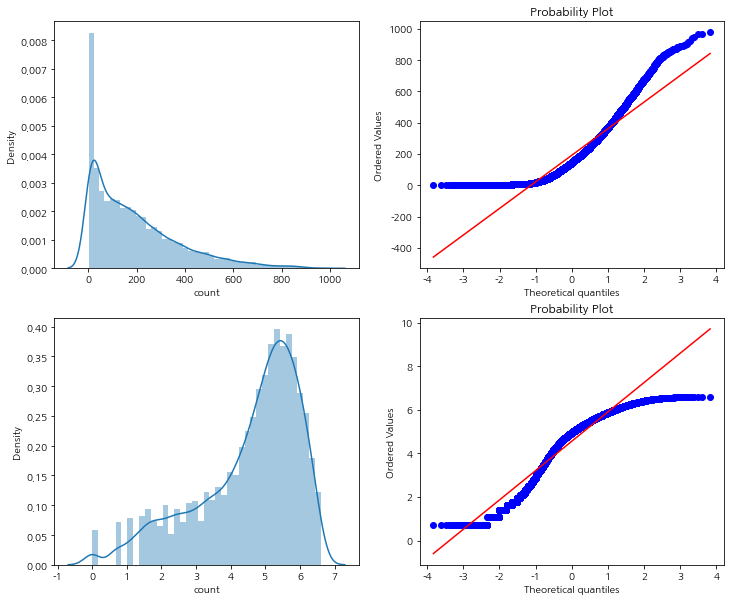

In [27]:
from scipy import stats

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sb.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sb.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

## 4 . 각 범주형 데이터 열에 대한 관련 열 추가 및 불필요한 열 제거 (데이터 전처리)

In [67]:
# 데이터 불러오기
train = pd.read_csv('/home/jaeyoon89/jaeyoon_study/train_bike.csv',parse_dates=["datetime"])
test = pd.read_csv('/home/jaeyoon89/jaeyoon_study/test_test.csv',parse_dates=["datetime"])

In [68]:
train.shape

(10886, 12)

In [69]:
test.shape

(6493, 9)

train와 test 데이터를 datetime으로 세분화 하자.

In [70]:
train["year"] = train["datetime"].dt.year         # 년
train["month"] = train["datetime"].dt.month       # 월
train["day"] = train["datetime"].dt.day           # 일
train["hour"] = train["datetime"].dt.hour         # 시간
train["minute"] = train["datetime"].dt.minute     # 분
train["second"] = train["datetime"].dt.second     # 초
train["dayofweek"] = train["datetime"].dt.dayofweek     # 요일
train.shape

(10886, 19)

In [71]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

앞서 산점도로 그려 보았던 풍속에 대한 시각화를 해보자. 풍속에 0 값이 가장 많다. 잘못된 0값을 수정해 줄 필요가 있어 보인다.

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

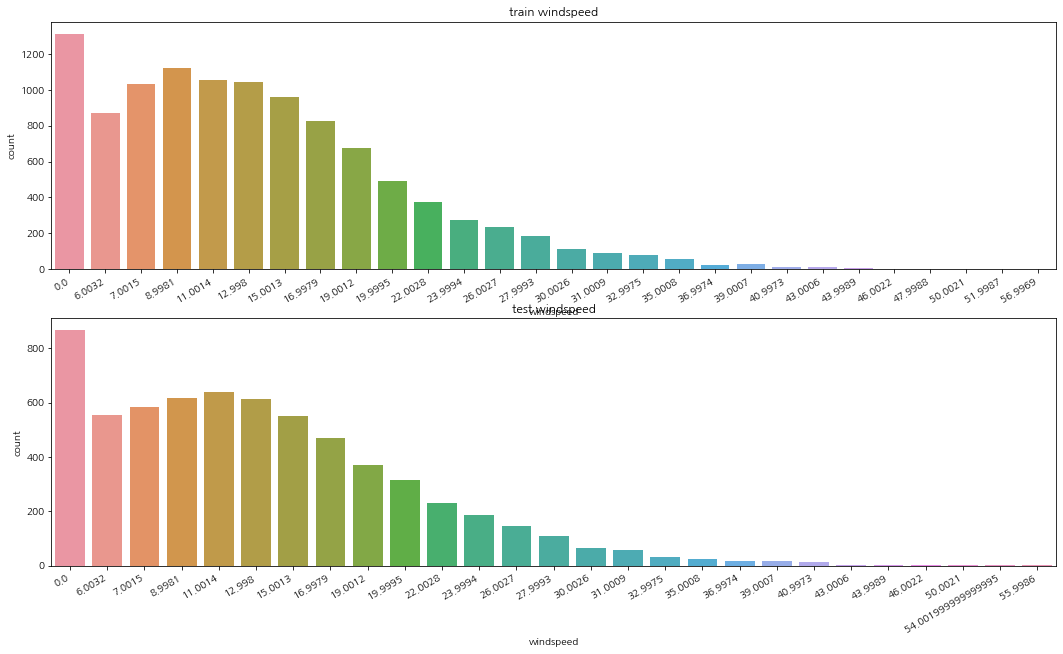

In [72]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sb.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sb.countplot(data=test, x="windspeed", ax=axes[1])

풍속이 0인것과 아닌 것의 세트를 나누어 준다.

In [73]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


그리고 풍속이 0인 것을 결측치로 보고 머신러닝으로 예측을 해서 풍속을 넣어 주자.

In [74]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

/home/jaeyoon89/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/jaeyoon89/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

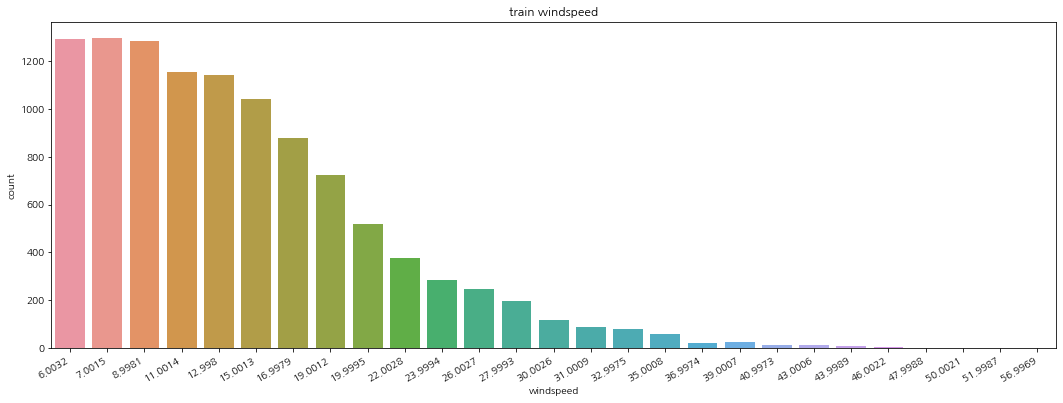

In [75]:
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')  # x축 글자를 30도 틀어서 글자가 겹치는 것을 방지한다.
ax1.set(ylabel='Count',title="train windspeed")
sb.countplot(data=train, x="windspeed", ax=ax1)

0값을 랜덤포레스트 분류를 사용해 예측된 값을 넣은 결과 위 그래프처럼 0값이 모두 제거된 것을 확인할 수 있다.

## 5. feature 선택하기

좋은 예측에 필요한 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거해보자.
연속형 피처는 온도, 습도, 풍속은 숫자의 크기에 따라 높고 낮음을 알 수 있지만, 범주형 피처는 요일,계절등을 0,1,2,3으로 나타낸 것이기 때문에 원-핫 코딩으로 바꿔줄 필요가 있다. 여기서는 범주형 피처를 카테고리를 통해 바꾸어 보자.

- 연속형 피처 = temp,humidity,windspeed,atemp
- 범주형 피처 = season,holiday,workingday,weather,dayofweek,month,year,hour

In [76]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [77]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [78]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [79]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [80]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## 6. Score 확인

### - RMLSE

In [81]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### - 교차검증

교차 검증을 10개로 나누어 학습해 보자.

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

### - RandomForest

n_estimastor를 기본값 100으로 지정하여 예측해 보자.

In [121]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [122]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print("Score= {0:.5f}".format(score))

CPU times: user 4.09 s, sys: 1.16 s, total: 5.25 s
Wall time: 9.72 s
Score= 0.33094


약 0.33의 점수가 나왔다. 0에 근접할수록 좋은 점수이다.

### - 훈련하기

In [101]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

### - 예측하기

In [102]:
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.58,   4.99,   3.98,   3.56,   3.18,   6.34,  38.22, 105.43,
       235.69, 135.83])

예측한 데이터를 시각화 해보자.

/home/jaeyoon89/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jaeyoon89/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

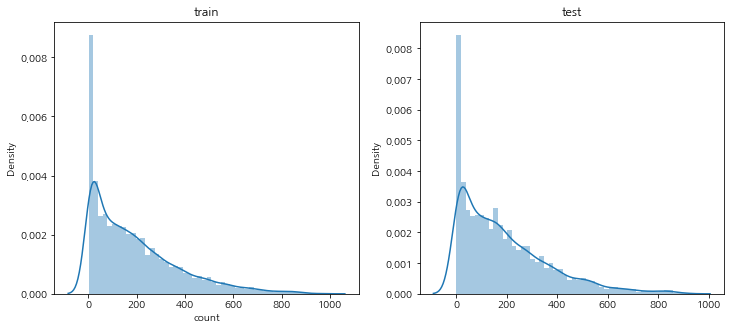

In [103]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sb.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sb.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

In [115]:
submission = pd.DataFrame({
        "datetime": test["datetime"],
        "count" : predictions
    })

## 7. 제출하기

In [116]:
submission.to_csv('/home/jaeyoon89/kaggle_bike_demand_sharing/score_bike_sharing.csv', index=False)

In [117]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.58
1,2011-01-20 01:00:00,4.99
2,2011-01-20 02:00:00,3.98
3,2011-01-20 03:00:00,3.56
4,2011-01-20 04:00:00,3.18


![](bike_score.PNG)

0.41866 이라는 점수가 나왔다. 더 좋은 점수를 위해 데이터 전처리에 있어 다른 방향으로 해볼 필요가 있어 보인다. 그리고 xgboost를 이용하여 예측을 해볼 필요가 있을 것 같다.